# Kaggle Trial for Predict Future Sales with TS

Hopefully this is will work!!

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all of them 
sales=pd.read_csv("sales_train.csv")
item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

In [3]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [5]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

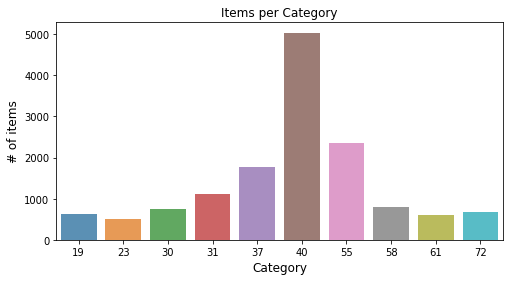

In [6]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:
The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

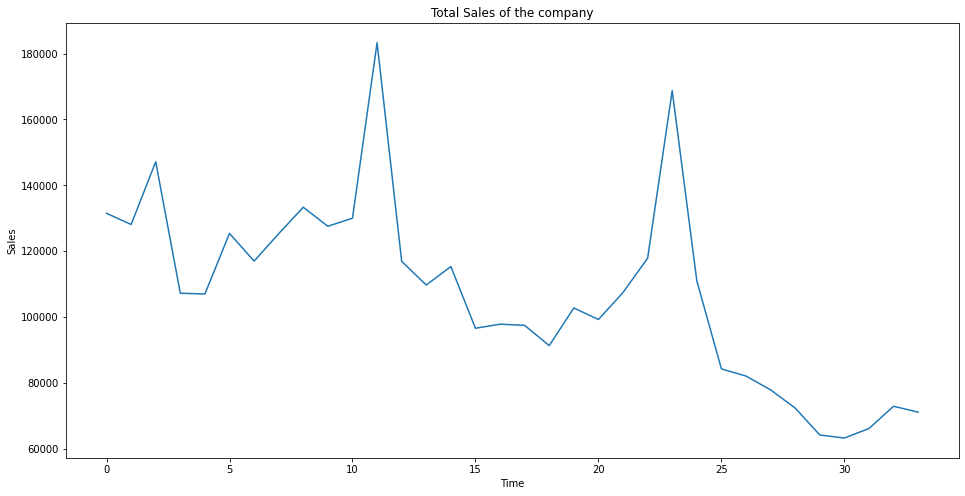

In [7]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

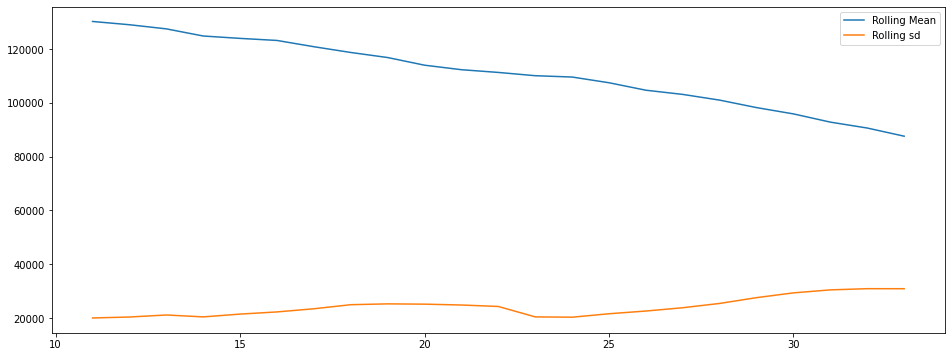

In [8]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()

### _Quick observations:_ There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

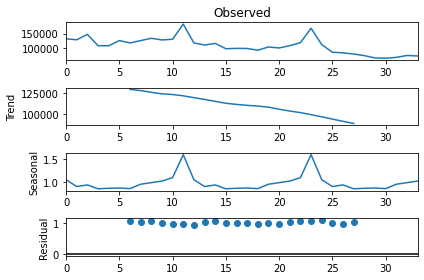

In [9]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

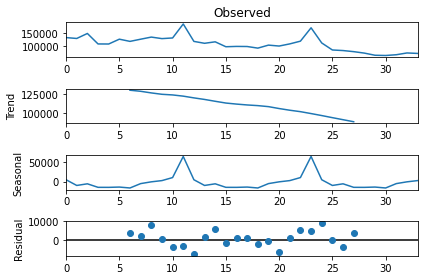

In [10]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [11]:
# R version ported into python  

# alas ! rpy2 does not exist in Kaggle kernals :( 
# from rpy2.robjects import r
# def decompose(series, frequency, s_window, **kwargs):
#     df = pd.DataFrame()
#     df['date'] = series.index
#     s = [x for x in series.values]
#     length = len(series)
#     s = r.ts(s, frequency=frequency)
#     decomposed = [x for x in r.stl(s, s_window, **kwargs).rx2('time.series')]
#     df['observed'] = series.values
#     df['trend'] = decomposed[length:2*length]
#     df['seasonal'] = decomposed[0:length]
#     df['residual'] = decomposed[2*length:3*length]
#     return df

# Help

we assume an additive model, then we can write
yt=St+Tt+Et
where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model,
yt=St x Tt x Et
# Stationarity:
Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

There are multiple tests that can be used to check stationarity.

* ADF( Augmented Dicky Fuller Test)
* KPSS
* PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.
Note: Step by step guide to perform dicky fuller test in Excel
Another Useful guide

In [12]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
dtype: float64
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
dtype: float64
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [13]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

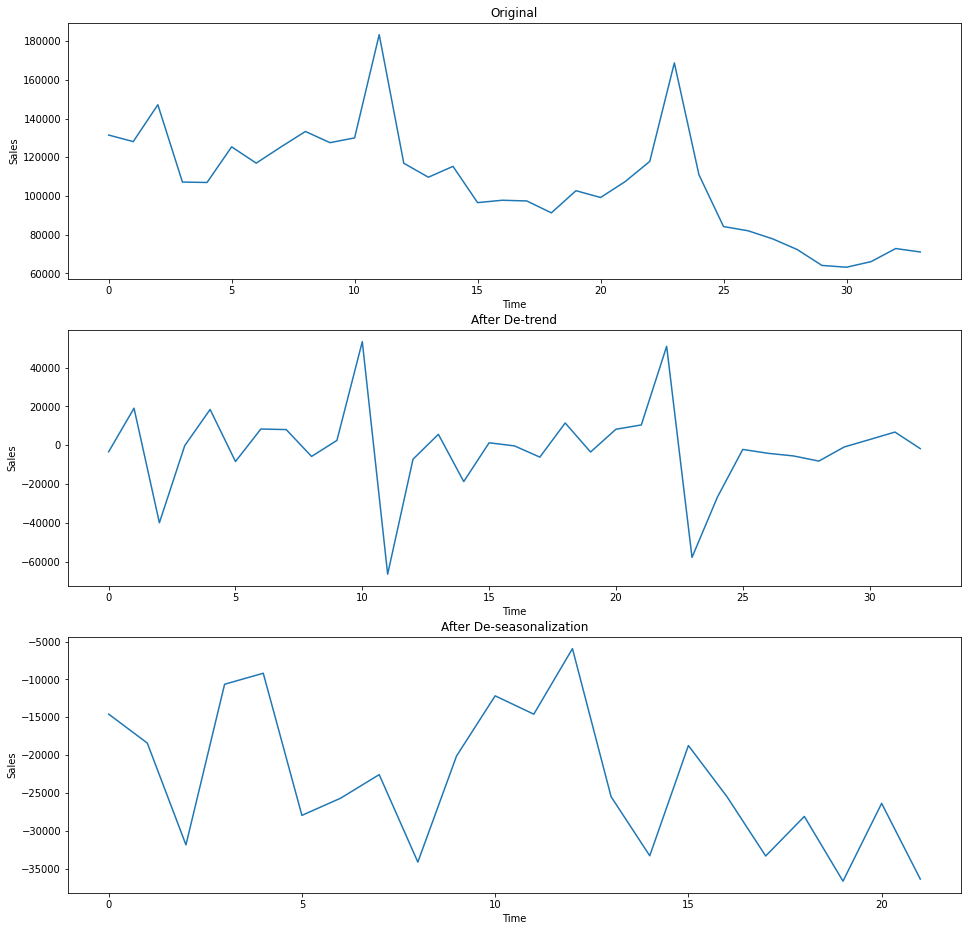

In [14]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [15]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
dtype: float64
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
dtype: float64
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!

# AR, MA and ARMA models:
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values ARMA - a mixture of both.

Now, How do we find out, if our time-series in AR process or MA process?

Let's find out!

In [16]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

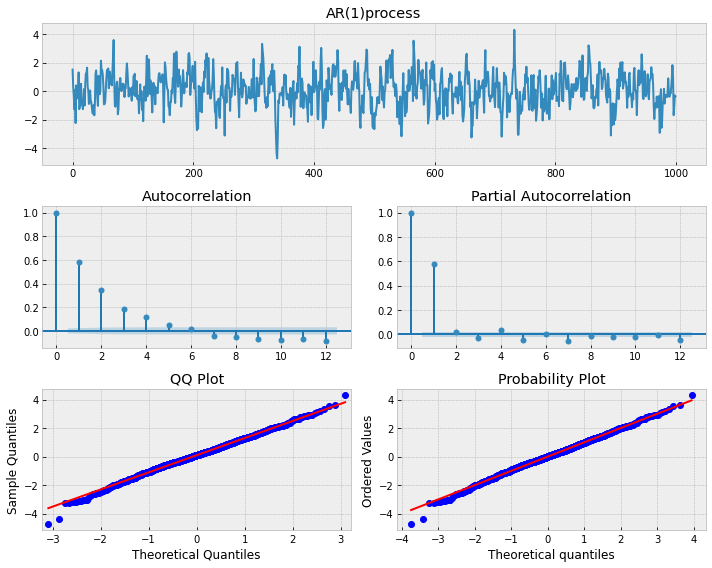

In [17]:

# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")